# Building a multi-agent with LangGraph 🦜🕸️

In this notebook, we're going to build a multi-agent system that can handle complex customer support queries for a digital music store. We'll be covering core LangGraph/LangGraph Platform concepts such as human-in-the-loop, the remote graph interface, and short/long-term memory.

![Architecture](images/architecture.png)

Our agent is connected to the [Chinook database](https://www.sqlitetutorial.net/sqlite-sample-database/), and is able to handle queries related to customer information, invoices, and the products offered by the store. **Our multi-agent system will utilize 3 sub-agents that have been built and deployed** by our teammates: 
1. Customer information subagent – Manages customer account details (name, address, phone, email).
2. Music catalog information subagent – Provides information about the digital music store’s catalog (albums, tracks, songs).
3. Invoice information subagent – Retrieves a customer’s past purchases or invoices.


## Part 1. Building the Agent

In [1]:
%%capture --no-stderr
%pip install python-dotenv langgraph typing-extensions langchain-core langchain-openai langchain-anthropic langchain-community scikit-learn openai ipython openevals


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#### Set Up

Let's load the environment variables from our .env file and define an LLM that'll power our agent.

In [2]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv(dotenv_path=".env", override=True)

# Alternatively, you can use AzureChatOpenAI()
# model = AzureChatOpenAI()
model = ChatOpenAI(model="gpt-4o")

#### State

First, we'll initialize **state**, which is the short term memory of our agent. At a low level, our agent's state is the input schema that’s shared across all the the nodes and edges in our graph. Our state will track the following fields: 
1. The user's initial request
2. The agent's action plan
3. What steps the agent has executed so far
4. Conversation history 
5. Final response

In [3]:
from typing_extensions import TypedDict
from typing import Annotated, List, Tuple, Literal, Union
from langgraph.graph.message import AnyMessage, add_messages
import operator

class State(TypedDict):
    original_objective: str
    action_plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    messages: Annotated[list[AnyMessage], add_messages]
    response: str

Now, let's define a system prompt for our agent that we'll reuse throughout the notebook.

In [4]:
supervisor_reusable_context = """You are an expert customer support assistant for a digital music store. 
You are dedicated to providing exceptional service and ensuring customer queries are answered thoroughly. 
You have a team of subagents that you can use to help answer queries from customers. 
Your primary role is to serve as a supervisor/planner for this multi-agent team that helps answer queries from customers. 
The multi-agent team you are supervising is responsible for handling questions related to the digital music store's music 
catalog (albums, tracks, songs, etc.), information about a customer's account (name, email, phone number, address, etc.), 
and information about a customer's past purchases or invoices. Your team is composed of three subagents that you can use 
to help answer the customer's request:

1. customer_information_subagent: this subagent is able to retrieve and update the personal information associated with 
a customer's account in the database (specifically, viewing or updating a customer's name, address, phone number, or email).
2. music_catalog_information_subagent: this subagent is able to retrieve information about the digital music store's music 
catalog (albums, tracks, songs, etc.) from the database.
3. invoice_information_subagent: this subagent is able to retrieve information about a customer's past purchases or invoices 
from the database. \n"""

#### Initializing Short-term & Long-term Memory
**Long term memory** stores information that is persisted across threads. Let's first define the long term memory store where we will be saving our user's music preferences.

We will also initialize a checkpointer for **short-term memory**. Short-term memory is persisted across a single thread. 

In [5]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore

# Initializing long term memory store 
in_memory_store = InMemoryStore()

# Initializing checkpoint for thread-level memory 
checkpointer = MemorySaver()

### Node 1: Supervisor
Now that we've initialized our agent's short and long term memory, we're ready to start building our first node.

Our first node is responsible for taking in a customer's query and generating an action plan to answer it. This action plan will include the steps we need to execute and the subagent that should handle each step. Our supervisor is able to use the agent's long term memory to personalize the plan to the user.

In [6]:
from pydantic import BaseModel, Field

class Step(BaseModel):
    description: str = Field(description="Description of the step to be performed")
    subagent: Literal["customer_information_subagent", "music_catalog_information_subagent", "invoice_information_subagent"] = Field(
        description="Name of the subagent that should execute this step"
    )
    
class Plan(BaseModel):
    steps: List[Step] = Field(
        description="Different steps that the subagents should follow to answer the customer's request, in chronological order"
    )

In [7]:
from langchain_core.runnables import RunnableConfig
from langgraph.store.base import BaseStore
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

supervisor_prompt = supervisor_reusable_context + """
Your role is to create an action plan that the subagents can follow and execute to thoroughly answer the customer's request. 
Your action plan should specify the exact steps that should be followed by the subagent(s) in order to successfully answer 
the customer's request, and which subagent should perform each step. Return the action plan as a list of objects, where each 
object contains the following fields:
- step: a detailed step that should be followed by subagent(s) in order to successfully answer a portion of the customer's request.
- subagent_to_perform_step: the subagent that should perform the step.

Return the action plan in chronological order, starting with the first step to be performed, and ending with the last step 
to be performed. You should try your best not to have multiple steps performed by the same subagent. This is inefficient. 
If you need a subagent to perform a task, try and group it all into one step.

You have existing information/long term memory about the customer that you can use to help you create the action plan. 
The existing information about the customer is as follows:
{existing_customer_information}

If you do not need a subagent to answer the customer's request, do not include it in the action plan/list of steps. Your goal 
is to be as efficient as possible, while ensuring that the customer's request is answered thoroughly. Take a deep breath and 
think carefully before responding. Go forth and make the customer delighted!
"""

# helper 
def format_user_memory(user_data):
    """Fetches music preferences from users, if available."""
    profile = user_data['memory']
    result = ""
    if hasattr(profile, 'music_preferences') and profile.music_preferences:
        result += f"Music Preferences: {', '.join(profile.music_preferences)}"
    return result.strip()


# helper 
def format_action_plan(steps_list):
    """
    Process a list of Step objects and format them into a comprehensive summary string.
    
    Args:
        steps_list: List of Step objects with description and subagent attributes
        
    Returns:
        Formatted string with key information about agent actions
    """
    summary = "# ACTION PLAN: \n\n"
    
    for i, step in enumerate(steps_list, 1):
        # Extract information from Step object
        task_description = step.description
        subagent = step.subagent
        
        # Format the action summary
        summary += f"## Action {i}\n\n"
        summary += f"### Agent\n{subagent}\n\n"
        summary += f"### Task\n{task_description}\n\n"
        
        # Add separator between actions except for the last one
        if i < len(steps_list):
            summary += "---\n\n"
    return summary



# Node 
def supervisor(state: State, config: RunnableConfig, store: BaseStore) -> dict:
    """Fetches relevant memory profiles and returns an plan"""
    
    print("\n" + "="*50 + "🎯 SUPERVISOR FUNCTION CALLED" + "="*50)
    
    # Fetch existing user memory from long term memory store 
    user_id = config["configurable"].get("user_id")
    namespace = ("memory_profile", user_id)
    existing_memory = store.get(namespace, "user_memory")
    formatted_memory = ""
    if existing_memory and existing_memory.value:
        formatted_memory = format_user_memory(existing_memory.value)

    # Fetch user input  
    first_message = state["messages"][-1]

    # Enforce structured output from LLM 
    structured_model = model.with_structured_output(Plan)
    result = structured_model.invoke([
        SystemMessage(content=supervisor_prompt.format(existing_customer_information=formatted_memory))
    ] + [first_message])

    formatted_action_plan = "Based on the plan, there is no need to route to sub-agents." 
    
    if result.steps: 
        formatted_action_plan = format_action_plan(result.steps)

    print("System Message: " + formatted_action_plan)
    
    return {
        # Update State
        "action_plan": result.steps,
        "original_objective": first_message.content,
        # Streaming intermediatery inputs
        "messages": [SystemMessage(content=formatted_action_plan)]
    }

### Node 2: User input
In the second node, we are introducing **human-in-the-loop**. This will allow the customer to give feedback on the action plan. We will take in the user's feedback and update the action plan accordingly. If there is no feedback, we won't change the initial plan. 

In [8]:
class PlanWithUserInput(BaseModel):
    steps: List[Step] = Field(
        description="Different steps that the subagents should follow to answer the customer's request, in chronological order"
    )
    updated_objective: str = Field(
        description="The updated objective/request from the customer, after taking into account the user's input/ideas for improvement"
    )

In [9]:
from langgraph.types import interrupt, Command

# Prompt 

replan_with_user_input_prompt = supervisor_reusable_context + """
Before you, another supervisor/planner has already created an action plan for the subagents to follow. 
This action plan was then shown to the customer so they could provide feedback and ideas for improvement. 

Your job is to take the customer's feedback and update the action plan and their original request/objective 
accordingly. Below, I have attached the previous action plan, the customer's original request/objective that 
the action plan was created for, and the feedback/ideas for improvement from the customer.

Please take this feedback and construct a new action plan/original objective that the subagents can follow to 
thoroughly answer the customer's request. If the feedback is not relevant or nonsensical, you can ignore it, 
and keep the original action plan/original objective.

The updated action plan should specify the exact steps that should be followed by the subagent(s) in order to 
successfully answer the customer's request, and which subagent should perform each step. Return the action plan 
as a list of objects, where each object contains the following fields:
- step: a detailed step that should be followed by the subagent(s) in order to successfully answer a portion of 
the customer's request.
- subagent_to_perform_step: the subagent that should perform the step.

The updated objective should be a detailed description of the customer's request/objective, after taking into 
account the customer's feedback/ideas for improvement.

Return the action plan in chronological order, starting with the first step to be performed, and ending with 
the last step to be performed. You should try your best not to have multiple steps performed by the same subagent. 
This is inefficient. If you need a subagent to perform a task, try and group it all into one step.

If you do not need a subagent to answer the customer's request, do not include it in the action plan/list of steps. 
Your goal is to be as efficient as possible, while ensuring that the customer's request is answered thoroughly and 
to the best of your ability.

Use the information below to update the action plan and customer's objective based on their feedback/ideas for improvement.

*IMPORTANT INFORMATION BELOW*

Your original objective/request from the customer was this:
{original_objective}

The original action plan constructed by the previous supervisor/planner was this:
{formatted_action_plan}

The customer's feedback/ideas for improvement are as follows:
{user_input}
"""



# Node 
def human_input(state: State, config: RunnableConfig, store: BaseStore) -> dict:
    print("\n" + "="*50 + "👤 HUMAN INPUT FUNCTION CALLED" + "="*50)
    
    user_input = interrupt({"Task": "Review the generated plan and suggest any revisions."})
    
    original_objective = state["original_objective"]
    formatted_action_plan = format_action_plan(state["action_plan"])
    
    # structure model output 
    structured_model = model.with_structured_output(PlanWithUserInput)
    
    if user_input != "": 
        result = structured_model.invoke([SystemMessage(content=replan_with_user_input_prompt.format(original_objective=original_objective, formatted_action_plan=formatted_action_plan, user_input=user_input))])
        updated_action_plan = "Updated action plan based on user proposal: \n" + format_action_plan(result.steps)
        print(updated_action_plan)
        return {
            # update state 
            "action_plan": result.steps,
            "original_objective": result.updated_objective,
            "messages": [SystemMessage(content=updated_action_plan)]
        }
    else:
        update_msg = "No updates from user input. Will proceed with the original plan."
        print("System Message: " + update_msg)
        return{
            "messages": [SystemMessage(content=update_msg)]
        }

### Node 3. Agent executor

The **RemoteGraph** interface from LangGraph Platform enables seamless interaction with deployed agents.

My teammates have built and deployed three specialized subagents:
1. customer_information_subagent – Manages customer account details (name, address, phone, email).
2. music_catalog_information_subagent – Provides information about the digital music store’s catalog (albums, tracks, songs).
3. invoice_information_subagent – Retrieves a customer’s past purchases or invoices.

The agent_executor node determines the sub-agent to execute based on the step we are processing from the action plan, and leverages the RemoteGraph interface to call the relevant sub-agent.

In [10]:
from langgraph.pregel.remote import RemoteGraph
customer_information_deployment_url = "https://remote-customer-assistant-cbd474a176cb59fe87deddf6f14ce85c.us.langgraph.app"
music_catalog_information_deployment_url = "https://remote-music-assistant-56295a1f54e5561f812da52437d18097.us.langgraph.app"
invoice_information_deployment_url = "https://remote-invoice-assistant-986c987c38e9536ea5aa870c6082254e.us.langgraph.app"

customer_information_remote_graph = RemoteGraph("agent", url=customer_information_deployment_url)
music_catalog_information_remote_graph = RemoteGraph("agent", url=music_catalog_information_deployment_url)
invoice_information_remote_graph = RemoteGraph("agent", url=invoice_information_deployment_url)

In [11]:
def agent_executor(state: State, config: RunnableConfig, store: BaseStore) -> dict:
    print("\n" + "="*50 + "🤖 AGENT EXECUTOR FUNCTION CALLED" + "="*50)
    plan = state["action_plan"]

    if plan: 
        total_plan = "\n".join([
            f"{i+1}. {step.subagent} will: {step.description}" 
            for i, step in enumerate(plan)
        ])
        first_task_subagent = plan[0].subagent
        first_task_description = plan[0].description
        first_task_subagent_response = first_task_subagent + " executed logic to answer the following request from the planner/supervisor: " + first_task_description + ".\n Please output your report on your work progress to your supervisor as a update on your action and progress, rather than a end-user facing message. "
        task_formatted_prompt = f"""For the following plan: 
        {total_plan}
        You are tasked with executing the first step #1. {first_task_subagent} will: {first_task_description}
        """
        # Calls the appropriate sub-agent with context
        if first_task_subagent == "customer_information_subagent":
            response = customer_information_remote_graph.invoke({"messages": [HumanMessage(content=task_formatted_prompt)]})["messages"]
            final_response = response[-1]['content']
        elif first_task_subagent == "music_catalog_information_subagent":
            response = music_catalog_information_remote_graph.invoke({"messages": [HumanMessage(content=task_formatted_prompt)]})["messages"]
            final_response = response[-1]['content']
        elif first_task_subagent == "invoice_information_subagent":
            response = invoice_information_remote_graph.invoke({"messages": [HumanMessage(content=task_formatted_prompt)]})["messages"]
            final_response = response[-1]['content']

        system_msg = "Executed " + first_task_subagent + ":\n" + final_response
        print("System Message: " + system_msg)
            
        return {
            # Update State 
            "past_steps": [
                (first_task_subagent_response, final_response)
            ],
            "messages": [SystemMessage(content=system_msg)]
    } 
    else: 
        system_msg = "No agent executed based on current plan. Proceeding to replanner step."
        print("System Message: " + system_msg)
        return {
            "messages": [SystemMessage(content=system_msg)]
    } 
    

### Step 4: Replanner
The **replanner** node reviews the actions that have been taken by our sub-agents so far, and updates the action plan to ensure the customer's request is being answered correctly. This step helps our agent recover from failure states.

In [12]:
class Response(BaseModel):
    """Response to user."""
    response: str


class ReplannerResponse(BaseModel):
    action: Union[Response, Plan] = Field(
        description="The action to perform. If you no longer need to use the subagents to solve the customer's request, use Response. "
        "If you still need to use the subagents to solve the problem, construct and return a list of steps to be performed by the subagents, use Plan."
    )

In [13]:
replanner_prompt = supervisor_reusable_context + """Before you, another supervisor/planner has already created an action 
plan for the subagents to follow. I've attached the previous action plan, the customer's original request, and the steps 
that have already been executed by the subagents below. 
You should take this information and either update the plan, or return Response if you believe the customer's request has been answered 
thoroughly and you no longer need to use the subagents to solve the problem (including when their inquiry doesn't need any subagents).  

If you decide to update the action plan, your action plan should specify the exact steps that should be followed by the 
subagent(s) in order to successfully answer the customer's request, and which subagent should perform each step. Return 
the action plan as a list of objects, where each object contains the following fields:
- step: a detailed step that should be followed by subagent(s) in order to successfully answer a portion of the customer's request.
- subagent_to_perform_step: the subagent that should perform the step.

Return the action plan in chronological order, starting with the first step to be performed, and ending with the last step to be performed. 
You should try your best not to have multiple steps performed by the same subagent. This is inefficient. If you need a subagent to 
perform a task, try and group it all into one step.

If you do not need a subagent to answer the customer's request, do not include it in the action plan/list of steps. Your goal 
is to be as efficient as possible, while ensuring that the customer's request is answered thoroughly and to the best of your ability.

Use the information below to either update the action plan, or return Response if you believe the customer's request has been 
answered thoroughly and you no longer need to use the subagents to solve the problem. If you return Response, make sure it's a neatly formatted, thorough response that can be shown
to a customer. Make sure the response has all the information the customer needs, and is professional and friendly.

*IMPORTANT INFORMATION BELOW*

Your original objective/request from the customer was this:
{original_objective}

The original action plan constructed by the previous supervisor/planner was this:
{formatted_action_plan}

The subagents have already executed the following steps:
{formatted_steps}

If no more steps are needed and you are ready to respond to the customer, use Response. If you still need to use the subagents to solve the problem, construct and return a list of steps to be performed by the subagents using Plan.
"""


# helpers 
def format_steps(steps_list):
    """
    Convert a list of Step objects into a neatly formatted string.
    
    Args:
        steps_list: List of Step objects
        
    Returns:
        A formatted string containing all key information
    """
    formatted_output = "# STEPS ALREADY PERFORMED BY THE SUBAGENTS\n\n"
    
    for i, step in enumerate(steps_list, 1):
        context_on_step = step[0]
        result_of_step = step[1]
        formatted_output += f"## Step {i}\n\n"
        formatted_output += f"### Task Description\n{context_on_step}\n\n"
        formatted_output += f"### Result\nThe following is the response returned after the subagent performed the task above:\n\n"
        # Add the result content
        formatted_output += f"{result_of_step}\n\n"    
        # Add separator between steps
        if i < len(steps_list):
            formatted_output += "---\n\n"
    return formatted_output


# Node 
def replanner(state: State, config: RunnableConfig, store: BaseStore) -> dict:
    print("\n" + "="*50 + "🔄 REPLANNER FUNCTION CALLED" + "="*50)
    
    # Fetch from state 
    original_objective = state["original_objective"]
    previous_action_plan = state["action_plan"]
    previous_steps = state["past_steps"]

    # format action steps & action plan 
    formatted_action_plan = format_action_plan(previous_action_plan)
    formatted_steps = format_steps(previous_steps)

    # structured output with response or updated action_plan 
    structured_model = model.with_structured_output(ReplannerResponse)
    result = structured_model.invoke([SystemMessage(content=replanner_prompt.format(original_objective = original_objective, formatted_action_plan = formatted_action_plan, formatted_steps = formatted_steps) )])
    if isinstance(result.action, Response):
        print("System Message: " + result.action.response)
        return {"response": result.action.response, "messages": [SystemMessage(content=result.action.response)]}
    else:
        formatted_update_plan = "Action plan has been updated. \n" + format_action_plan(result.action.steps)
        print("System Message: " + formatted_update_plan)
        return {"action_plan": result.action.steps, "messages": [SystemMessage(content=formatted_update_plan)]}

When we're ready to return an answer to the user, we want to output the response, not an updated plan. To accomplish this, we'll define a **conditional edge**. Inside the conditional edge, we will:
1. Update our agent's long term memory and route to END if we've finished executing the plan
2. Route back to the agent_executor with the updated plan if we still need to take action

In [14]:
class UserProfile(BaseModel):
    customer_id: str = Field(
        description="The customer ID of the customer"
    )
    music_preferences: List[str] = Field(
        description="The music preferences of the customer"
    )

In [15]:
create_memory_prompt = """You are an expert analyst that is observing a conversation that has taken place between a customer and a customer support assistant. The customer support assistant works for a digital music store, and has utilized a multi-agent team to answer the customer's request. 
You are tasked with analyzing the conversation that has taken place between the customer and the customer support assistant, and updating the memory profile associated with the customer. The memory profile may be empty. If it's empty, you should create a new memory profile for the customer.

You specifically care about saving any music interest the customer has shared about themselves, particularly their music preferences to their memory profile.

To help you with this task, I have attached the conversation that has taken place between the customer and the customer support assistant below, as well as the existing memory profile associated with the customer that you should either update or create. 

The customer's memory profile should have the following fields:
- customer_id: the customer ID of the customer
- music_preferences: the music preferences of the customer

These are the fields you should keep track of and update in the memory profile. If there has been no new information shared by the customer, you should not update the memory profile. It is completely okay if you do not have new information to update the memory profile with. In that case, just leave the values as they are.

*IMPORTANT INFORMATION BELOW*

The conversation between the customer and the customer support assistant that you should analyze is as follows:
{conversation}

The existing memory profile associated with the customer that you should either update or create based on the conversation is as follows:
{memory_profile}

Ensure your response is an object that has the following fields:
- customer_id: the customer ID of the customer
- music_preferences: the music preferences of the customer

For each key in the object, if there is no new information, do not update the value, just keep the value that is already there. If there is new information, update the value. 

Take a deep breath and think carefully before responding.
"""

def should_end(state: State, config: RunnableConfig, store: BaseStore):
    print("\n" + "="*50+"🎬 SHOULD_END FUNCTION CALLED"+"="*50)
    
    past_messages = state["messages"]
    
    if "response" in state and state["response"]:
        # Fetch and update memory 
        user_id = config["configurable"].get("user_id")
        namespace = ("memory_profile", user_id)
        existing_memory = store.get(namespace, "user_memory")
        if existing_memory and existing_memory.value:
            existing_memory_dict = existing_memory.value
            formatted_memory = (
                f"Music Preferences: {', '.join(existing_memory_dict.get('music_preferences', []))}"
            )
        else:
            formatted_memory = ""
        formatted_system_message = SystemMessage(content=create_memory_prompt.format(conversation=past_messages, memory_profile=formatted_memory))
        structured_model = model.with_structured_output(UserProfile)
        updated_memory = structured_model.invoke([formatted_system_message])
        key = "user_memory"
        store.put(namespace, key, { "memory": updated_memory })
        return END
    else:
        return "agent_executor"

### Compile Graph
Now that we've defined our agent's memory, nodes, and edges, let's build and compile our graph!

In [16]:
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display

builder = StateGraph(State)
builder.add_node("supervisor", supervisor)
builder.add_node("agent_executor", agent_executor)
builder.add_node("replanner", replanner)
builder.add_node("human_input", human_input)
builder.add_edge(START, "supervisor")
builder.add_edge("supervisor", "human_input")
builder.add_edge("human_input", "agent_executor")
builder.add_edge("agent_executor", "replanner")
builder.add_conditional_edges(
    "replanner",
    should_end,
    ["agent_executor", END],
)

memory_saver = MemorySaver()
graph = builder.compile(checkpointer=memory_saver, store=in_memory_store)

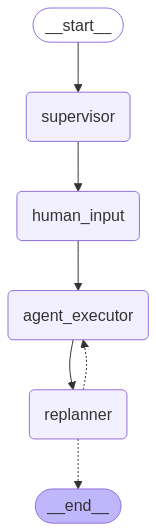

In [17]:
display(Image(graph.get_graph().draw_mermaid_png()))

### Let's test it out!

In [18]:
initial_input = { "messages": [HumanMessage(content="my customer ID is 1. what is my name? also, whats my most recent purchase? and what albums does the catalog have by U2")] }
thread = {"configurable": {"thread_id": "5", "user_id": "50"}}

# Run the graph until the first interruption
result = graph.invoke(initial_input, config = thread) 
print("Would you like to make any revisions to the plan?")


==================================================🎯 SUPERVISOR FUNCTION CALLED==================================================
System Message: # ACTION PLAN: 

## Action 1

### Agent
customer_information_subagent

### Task
Retrieve the name associated with customer ID 1 from the customer database.

---

## Action 2

### Agent
invoice_information_subagent

### Task
Retrieve the most recent purchase made by customer ID 1 from the invoice database.

---

## Action 3

### Agent
music_catalog_information_subagent

### Task
Search the music catalog database for albums by the artist U2.



==================================================👤 HUMAN INPUT FUNCTION CALLED==================================================
Would you like to make any revisions to the plan?


In [19]:
# Resume interruption 
interrupt_info = ""
result = graph.invoke(Command(resume=interrupt_info), config = thread)


==================================================👤 HUMAN INPUT FUNCTION CALLED==================================================
System Message: No updates from user input. Will proceed with the original plan.

==================================================🤖 AGENT EXECUTOR FUNCTION CALLED==================================================
System Message: Executed customer_information_subagent:
The name associated with customer ID 1 is Luís Gonçalves. If you need further assistance, feel free to ask!

==================================================🔄 REPLANNER FUNCTION CALLED==================================================
System Message: Action plan has been updated. 
# ACTION PLAN: 

## Action 1

### Agent
invoice_information_subagent

### Task
Retrieve the most recent purchase made by customer ID 1 from the invoice database.

---

## Action 2

### Agent
music_catalog_information_subagent

### Task
Search the music catalog database for albums by the artist U2.



============

Let's take a look at the memory!

In [21]:
user_id = "50"
namespace = ("memory_profile", user_id)
memory = in_memory_store.get(namespace, "user_memory").value

saved_music_preferences = memory.get("memory").music_preferences

print(saved_music_preferences)

['U2']


Let's give feedback to the plan this time

In [22]:
initial_input = { "messages": [HumanMessage(content="my customer ID is 1. what is my name? also, whats my most recent purchase? and what albums does the catalog have by U2")] }
thread = {"configurable": {"thread_id": "103", "user_id": "50"}}

# Run the graph until the first interruption
result = graph.invoke(initial_input, config = thread) 
print("Would you like to make any revisions to the plan?")


==================================================🎯 SUPERVISOR FUNCTION CALLED==================================================
System Message: # ACTION PLAN: 

## Action 1

### Agent
customer_information_subagent

### Task
Retrieve the customer's name associated with customer ID 1.

---

## Action 2

### Agent
invoice_information_subagent

### Task
Retrieve the most recent purchase or invoice for customer ID 1.

---

## Action 3

### Agent
music_catalog_information_subagent

### Task
Retrieve all albums in the catalog by U2.



==================================================👤 HUMAN INPUT FUNCTION CALLED==================================================
Would you like to make any revisions to the plan?


In [23]:
# Resume interruption 
interrupt_info = "i forgot to include this in my original request, but do you also have any songs by Amy Winehouse?"
result = graph.invoke(Command(resume=interrupt_info), config = thread)


==================================================👤 HUMAN INPUT FUNCTION CALLED==================================================
Updated action plan based on user proposal: 
# ACTION PLAN: 

## Action 1

### Agent
customer_information_subagent

### Task
Retrieve the customer's name associated with customer ID 1.

---

## Action 2

### Agent
invoice_information_subagent

### Task
Retrieve the most recent purchase or invoice for customer ID 1.

---

## Action 3

### Agent
music_catalog_information_subagent

### Task
Retrieve all albums in the catalog by U2.

---

## Action 4

### Agent
music_catalog_information_subagent

### Task
Retrieve all songs by Amy Winehouse in the catalog.



==================================================🤖 AGENT EXECUTOR FUNCTION CALLED==================================================
System Message: Executed customer_information_subagent:
The customer's name associated with customer ID 1 is Luís Gonçalves. If you need further assistance, feel free to ask!